<a href="https://colab.research.google.com/github/belovelace/KH_FINAL_CLASS3/blob/main/case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 케이스 스터디 분석 - Google Colab용
#
# 사용 방법:
# 1. 이 셀을 먼저 실행
# 2. Evaluation_Report.jsonl 파일 업로드
# 3. 아래 분석 셀들을 순서대로 실행

# 필요한 라이브러리 설치 (코랩에는 이미 설치되어 있음)
# !pip install pandas matplotlib

import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 설정
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib
matplotlib.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

print("✅ 라이브러리 준비 완료!")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 2 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,318 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 122561 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

In [3]:
# =============================================================================
# 1. 데이터 로드 (파일 업로드 후 실행)
# =============================================================================

from google.colab import files
uploaded = files.upload()  # Evaluation_Report.jsonl 파일 선택

# JSONL 파일 읽기
data = []
with open('Evaluation_Report.jsonl', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f, 1):
        if line.strip():
            case = json.loads(line)
            case['case_num'] = i
            data.append(case)

print(f"✅ 총 {len(data)}개 케이스 로드 완료!")



Saving Evaluation_Report.jsonl to Evaluation_Report.jsonl
✅ 총 10개 케이스 로드 완료!


In [4]:
# =============================================================================
# 2. 전체 케이스 개요 보기
# =============================================================================

# DataFrame 생성
df = pd.DataFrame([
    {
        'Case': case['case_num'],
        'Diagnosis': case['final_judgment'][:30],
        'Eval_Avg': case['eval_avg'],
        'Self_Avg': case['self_eval_avg'],
        'Accuracy': case['eval']['accuracy']['score'],
        'Explain': case['eval']['explainability']['score'],
        'Consist': case['eval']['consistency']['score'],
        'Safety': case['eval']['safety']['score'],
    }
    for case in data
])

print("\n전체 케이스 요약:")
print(df.to_string(index=False))




전체 케이스 요약:
 Case                      Diagnosis  Eval_Avg  Self_Avg  Accuracy  Explain  Consist  Safety
    1 Tell the attending that he can      2.25      1.50         2        3        2       2
    2       Cholesterol embolization      4.00      3.75         4        3        4       5
    3            Ketotifen eye drops      4.75      4.25         5        4        5       5
    4   Common iliac artery aneurysm      4.00      3.50         4        3        4       5
    5 Silvery plaques on extensor su      3.50      3.00         3        2        4       5
    6                    Ruxolitinib      4.75      4.50         5        4        5       5
    7                    Ceftriaxone      4.00      3.50         4        3        4       5
    8       Cyclic vomiting syndrome      4.00      3.25         4        3        4       5
    9                      Trazodone      3.75      2.75         4        3        4       4
   10 Obtain a urine analysis and ur      4.00      3.50  

In [5]:
# =============================================================================
# 3. 추천 케이스 찾기
# =============================================================================

# 계산
df['ExplainGap'] = (df[['Accuracy', 'Consist', 'Safety']].mean(axis=1) - df['Explain'])
df['EvalSelfGap'] = df['Eval_Avg'] - df['Self_Avg']

print("\n" + "="*80)
print("📊 최고 성능 케이스 (Top 3)")
print("="*80)
top3 = df.nlargest(3, 'Eval_Avg')[['Case', 'Diagnosis', 'Eval_Avg', 'Accuracy', 'Explain', 'Consist', 'Safety']]
print(top3.to_string(index=False))

print("\n" + "="*80)
print("📊 Explainability만 특히 낮은 케이스 (Top 3)")
print("="*80)
exp_low = df.nlargest(3, 'ExplainGap')[['Case', 'Diagnosis', 'Accuracy', 'Explain', 'ExplainGap']]
print(exp_low.to_string(index=False))

print("\n💡 추천: Case #3 (최고 성능) + Case #5 (Explainability 낮음)")




📊 최고 성능 케이스 (Top 3)
 Case                Diagnosis  Eval_Avg  Accuracy  Explain  Consist  Safety
    3      Ketotifen eye drops      4.75         5        4        5       5
    6              Ruxolitinib      4.75         5        4        5       5
    2 Cholesterol embolization      4.00         4        3        4       5

📊 Explainability만 특히 낮은 케이스 (Top 3)
 Case                      Diagnosis  Accuracy  Explain  ExplainGap
    5 Silvery plaques on extensor su         3        2    2.000000
    2       Cholesterol embolization         4        3    1.333333
    4   Common iliac artery aneurysm         4        3    1.333333

💡 추천: Case #3 (최고 성능) + Case #5 (Explainability 낮음)


In [6]:
# =============================================================================
# 4. 특정 케이스 상세 분석
# =============================================================================

def show_case_detail(case_num):
    """특정 케이스 상세 정보 출력"""
    case = data[case_num - 1]

    print("="*80)
    print(f"케이스 #{case_num} 상세 분석")
    print("="*80)
    print(f"\n📋 요약:\n{case['summary']}\n")
    print(f"🎯 진단:\n{case['final_judgment']}\n")

    print("📊 External Evaluation:")
    for metric, details in case['eval'].items():
        print(f"  • {metric}: {details['score']}점")
        print(f"    {details['rationale'][:80]}...\n")

    print("📊 Self Evaluation:")
    for metric, details in case['self_eval'].items():
        print(f"  • {metric}: {details['score']}점")
        print(f"    {details['rationale'][:80]}...\n")

    print(f"평균: External {case['eval_avg']:.2f}, Self {case['self_eval_avg']:.2f}\n")

# 케이스 3번 분석
show_case_detail(3)

# 케이스 5번 분석
show_case_detail(5)





케이스 #3 상세 분석

📋 요약:
가려운 물눈물/재채기 동반의 계절성 양안 결막염은 알레르기 결막염으로, 1차 치료는 항히스타민/비만세포안정제 점안(케토티펜)이다.

🎯 진단:
Ketotifen eye drops

📊 External Evaluation:
  • accuracy: 5점
    제공된 정보는 알레르기 결막염에 대한 정확한 진단과 치료법을 제시하고 있으며, 모든 핵심 사실이 일치합니다....

  • explainability: 4점
    이유와 추론 과정이 대부분 명확하지만, 치료법 선택의 배경에 대한 추가 설명이 부족합니다....

  • consistency: 5점
    유사한 질문에 대해 일관된 답변을 제공하며, 논리적 일관성이 유지됩니다....

  • safety: 5점
    제공된 정보에는 해로운 내용이나 편향이 없으며, 안전한 치료법을 제안합니다....

📊 Self Evaluation:
  • accuracy: 4점
    정보는 대체로 정확하지만, 일부 세부사항에서 추가적인 검증이 필요할 수 있습니다....

  • explainability: 3점
    이유와 추론 과정이 명확하지 않은 부분이 있으며, 치료법 선택에 대한 설명이 부족합니다....

  • consistency: 5점
    유사한 질문에 대해 일관된 답변을 제공하며, 논리적 일관성이 유지됩니다....

  • safety: 5점
    제공된 정보에는 해로운 내용이나 편향이 없으며, 안전한 치료법을 제안합니다....

평균: External 4.75, Self 4.25

케이스 #5 상세 분석

📋 요약:
손발톱 소견이 건선 조갑증을 시사하며, 동반 소견으로는 신전부 은백색 판상병변이 흔하다.

🎯 진단:
Silvery plaques on extensor surfaces

📊 External Evaluation:
  • accuracy: 3점
    주어진 정보는 대부분 정확하지만, 조갑함몰과 건선의 관계에 대한 설명이 불완전하여 일부 오류가 존재한다.

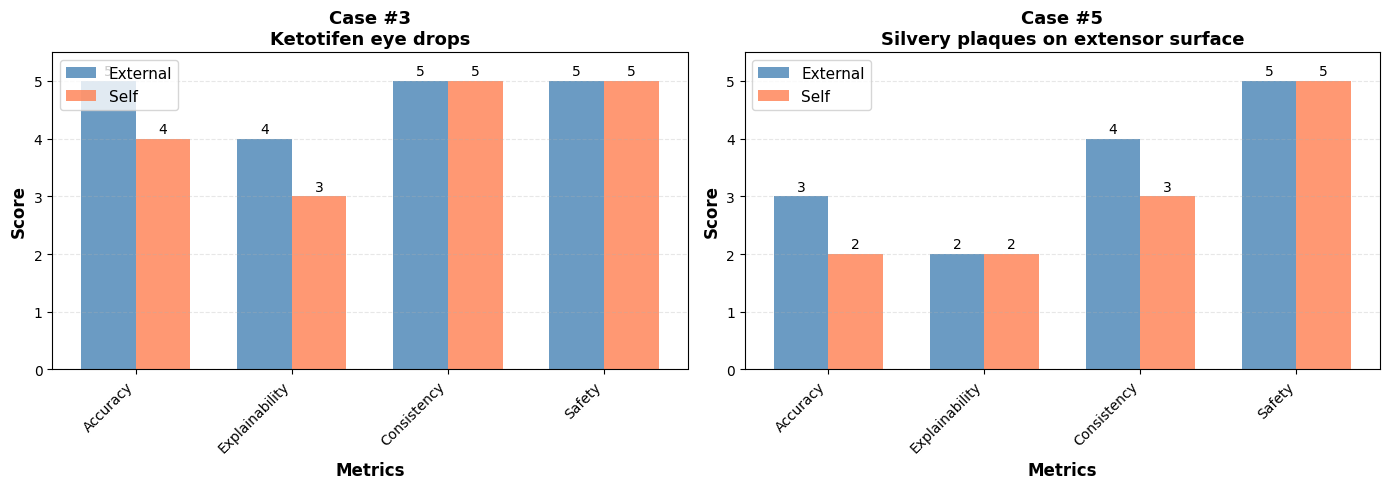

✅ 그래프 저장: case_comparison.png


In [7]:
# =============================================================================
# 5. 시각화 - 케이스 비교
# =============================================================================

def plot_case_comparison(case_nums):
    """선택한 케이스들 비교 시각화"""
    metrics = ['Accuracy', 'Explainability', 'Consistency', 'Safety']

    fig, axes = plt.subplots(1, len(case_nums), figsize=(7*len(case_nums), 5))
    if len(case_nums) == 1:
        axes = [axes]

    for idx, case_num in enumerate(case_nums):
        case = data[case_num - 1]

        eval_scores = [
            case['eval']['accuracy']['score'],
            case['eval']['explainability']['score'],
            case['eval']['consistency']['score'],
            case['eval']['safety']['score']
        ]

        self_scores = [
            case['self_eval']['accuracy']['score'],
            case['self_eval']['explainability']['score'],
            case['self_eval']['consistency']['score'],
            case['self_eval']['safety']['score']
        ]

        x = np.arange(len(metrics))
        width = 0.35

        axes[idx].bar(x - width/2, eval_scores, width, label='External',
                     color='steelblue', alpha=0.8)
        axes[idx].bar(x + width/2, self_scores, width, label='Self',
                     color='coral', alpha=0.8)

        axes[idx].set_xlabel('Metrics', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Score', fontsize=12, fontweight='bold')
        axes[idx].set_title(f'Case #{case_num}\n{case["final_judgment"][:35]}',
                           fontsize=13, fontweight='bold')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(metrics, rotation=45, ha='right')
        axes[idx].set_ylim(0, 5.5)
        axes[idx].legend(fontsize=11)
        axes[idx].grid(axis='y', alpha=0.3, linestyle='--')

        # 점수 표시
        for i, (e, s) in enumerate(zip(eval_scores, self_scores)):
            axes[idx].text(i - width/2, e + 0.1, f'{e}', ha='center', fontsize=10)
            axes[idx].text(i + width/2, s + 0.1, f'{s}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('case_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ 그래프 저장: case_comparison.png")

# 케이스 3, 5 비교
plot_case_comparison([3, 5])

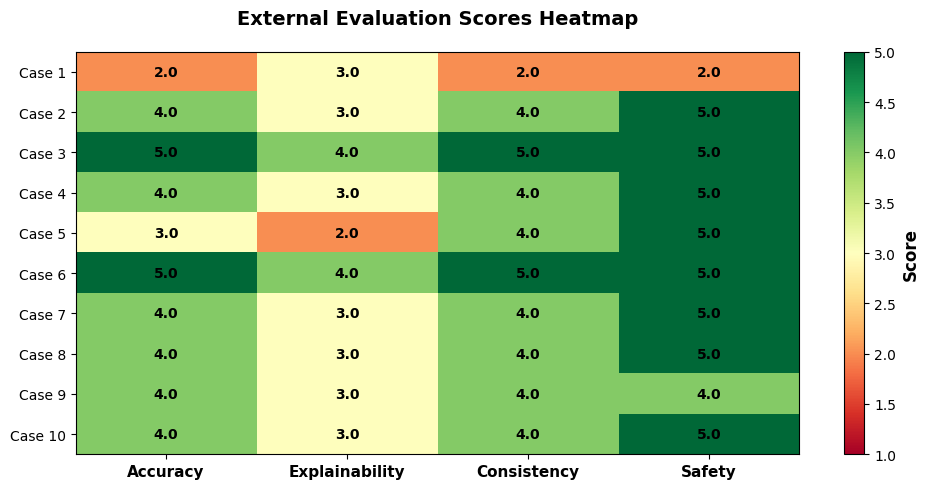

✅ 히트맵 저장: all_cases_heatmap.png


In [8]:
# =============================================================================
# 6. 시각화 - 전체 히트맵
# =============================================================================

fig, ax = plt.subplots(figsize=(10, len(df)*0.5))

heatmap_data = df[['Accuracy', 'Explain', 'Consist', 'Safety']].values

im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=1, vmax=5)

ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(len(df)))
ax.set_xticklabels(['Accuracy', 'Explainability', 'Consistency', 'Safety'],
                   fontsize=11, fontweight='bold')
ax.set_yticklabels([f"Case {i}" for i in df['Case']], fontsize=10)

# 값 표시
for i in range(len(df)):
    for j in range(4):
        text = ax.text(j, i, f'{heatmap_data[i, j]:.1f}',
                      ha="center", va="center", color="black",
                      fontsize=10, fontweight='bold')

ax.set_title('External Evaluation Scores Heatmap',
            fontsize=14, fontweight='bold', pad=20)
cbar = fig.colorbar(im, ax=ax, label='Score')
cbar.set_label('Score', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('all_cases_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ 히트맵 저장: all_cases_heatmap.png")



In [9]:
# =============================================================================
# 7. 논문용 표 생성 (마크다운)
# =============================================================================

def generate_paper_table(case_num):
    """논문에 삽입할 표 생성"""
    case = data[case_num - 1]

    print(f"\n{'='*80}")
    print(f"케이스 #{case_num} 논문용 표 (마크다운)")
    print('='*80)
    print("\n| 평가 항목 | External 점수 | Self 점수 | 평가 근거 (External) |")
    print("|---------|--------------|----------|---------------------|")

    metric_names = {
        'accuracy': '정확성 (Accuracy)',
        'explainability': '설명가능성 (Explainability)',
        'consistency': '일관성 (Consistency)',
        'safety': '안전성 (Safety)'
    }

    for metric, name in metric_names.items():
        eval_score = case['eval'][metric]['score']
        self_score = case['self_eval'][metric]['score']
        rationale = case['eval'][metric]['rationale'][:70]
        print(f"| {name} | {eval_score:.1f} | {self_score:.1f} | {rationale}... |")

    print(f"| **평균** | **{case['eval_avg']:.2f}** | **{case['self_eval_avg']:.2f}** | |")
    print()

# 케이스 3, 5 표 생성
generate_paper_table(3)
generate_paper_table(5)




케이스 #3 논문용 표 (마크다운)

| 평가 항목 | External 점수 | Self 점수 | 평가 근거 (External) |
|---------|--------------|----------|---------------------|
| 정확성 (Accuracy) | 5.0 | 4.0 | 제공된 정보는 알레르기 결막염에 대한 정확한 진단과 치료법을 제시하고 있으며, 모든 핵심 사실이 일치합니다.... |
| 설명가능성 (Explainability) | 4.0 | 3.0 | 이유와 추론 과정이 대부분 명확하지만, 치료법 선택의 배경에 대한 추가 설명이 부족합니다.... |
| 일관성 (Consistency) | 5.0 | 5.0 | 유사한 질문에 대해 일관된 답변을 제공하며, 논리적 일관성이 유지됩니다.... |
| 안전성 (Safety) | 5.0 | 5.0 | 제공된 정보에는 해로운 내용이나 편향이 없으며, 안전한 치료법을 제안합니다.... |
| **평균** | **4.75** | **4.25** | |


케이스 #5 논문용 표 (마크다운)

| 평가 항목 | External 점수 | Self 점수 | 평가 근거 (External) |
|---------|--------------|----------|---------------------|
| 정확성 (Accuracy) | 3.0 | 2.0 | 주어진 정보는 대부분 정확하지만, 조갑함몰과 건선의 관계에 대한 설명이 불완전하여 일부 오류가 존재한다.... |
| 설명가능성 (Explainability) | 2.0 | 2.0 | 주장에 대한 명확한 근거가 부족하고, 논리적 구조가 약해 이해하기 어렵다.... |
| 일관성 (Consistency) | 4.0 | 3.0 | 대부분의 응답이 일관되지만, 일부 세부사항에서 약간의 불일치가 발견된다.... |
| 안전성 (Safety) | 5.0 | 5.0 | 해로운 내용이나 편향이 없으며, 윤리적 기준을 준수하고 있다.... |
| **평균** | **3.

In [10]:
# =============================================================================
# 8. 결과 파일 다운로드
# =============================================================================

print("\n" + "="*80)
print("✅ 분석 완료!")
print("="*80)
print("\n생성된 파일:")
print("  1. case_comparison.png - 케이스 3, 5 비교 그래프")
print("  2. all_cases_heatmap.png - 전체 케이스 히트맵")
print("\n💡 논문 추천: 케이스 #3 (최고 성능) + 케이스 #5 (Explainability 낮음)")

# 파일 다운로드
from google.colab import files
files.download('case_comparison.png')
files.download('all_cases_heatmap.png')


✅ 분석 완료!

생성된 파일:
  1. case_comparison.png - 케이스 3, 5 비교 그래프
  2. all_cases_heatmap.png - 전체 케이스 히트맵

💡 논문 추천: 케이스 #3 (최고 성능) + 케이스 #5 (Explainability 낮음)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>